In [1]:
%reload_ext autoreload
%autoreload 2

import os
import torch
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path
from scipy import interpolate
from sklearn.preprocessing import normalize

# make x and y be a function of t
# t is the total distance traveled


def get_strokes(path, max_stroke_count=None):
    """
    Args:
        path: XML path to stroke file

    Returns:
        list of lists of dicts: each dict contains a stroke, keys: x,y, time
    """
    root = ET.parse(path).getroot()
    all_strokes = root[1]
    stroke_lists = []
    start_end_strokes_lists = []

    # If not constrained by number of strokes, set max_stroke_count to full length window
    if max_stroke_count is None:
        max_stroke_count = len(all_strokes) - 1
    
    for i in range(len(all_strokes) - max_stroke_count):
        strokes = all_strokes[i:i + max_stroke_count]
        stroke_list = []
        min_time = float(strokes[0][0].attrib["time"])
        last_time = 0
        stroke_delay = 0  # time between strokes
        start_end_strokes = [] # list of start times and end times between strokes; one before sequence starts!
        
        for stroke in strokes:
            x_coords = []
            y_coords = []
            time_list = []

            for i, point in enumerate(stroke):
                # print("Points", len(strokes))
                x, y, time = point.attrib["x"], point.attrib["y"], point.attrib["time"]
                x_coords.append(int(x))
                y_coords.append(-int(y))

                if i == 0:  # no time passes between strokes!
                    min_time += float(time) - min_time - last_time - .001
                    start_end_strokes.append((last_time, float(time) - min_time))

                next_time = float(time) - min_time

                if time_list and next_time == time_list[-1]:
                    next_time += .001
                    assert next_time > time_list[-1]

                # No repeated times
                if time_list and next_time <= time_list[-1]:
                    next_time = time_list[-1] + .001

                time_list.append(next_time)
            last_time = time_list[-1]
            stroke_list.append({"x": x_coords, "y": y_coords, "time": time_list})

        stroke_lists.append(stroke_list)
        start_end_strokes_lists.append(start_end_strokes)
        
    return stroke_lists, start_end_strokes_lists

def convert_strokes(stroke_list):
    x, y, time = [], [], []
    [x.extend(key["x"]) for key in stroke_list]
    [y.extend(key["y"]) for key in stroke_list]
    [time.extend(key["time"]) for key in stroke_list]
    return np.array(x), np.array(y), np.array(time)

def process(time):
    total_time = np.max(time) - np.min(time)


In [2]:
def normalize(my_array):
    return ((my_array-np.min(my_array))/(np.max(my_array)-np.min(my_array))-.5)*2

def get_gts(path, instances = 50):
    stroke_list, start_end_strokes = get_strokes(path)
    x,y,time = convert_strokes(stroke_list)

    # find dead timezones
    # make x and y independently a function of t
    time_continuum = np.linspace(np.min(time), np.max(time), instances)
    x_func = interpolate.interp1d(time, x)
    y_func = interpolate.interp1d(time, y)

    for i,t in enumerate(time_continuum):
        for lower, upper in start_end_strokes:
            if t < lower:
                break
            if t > lower and t < upper:
                t = lower if abs(t-lower)<abs(t-upper) else upper
                time_continuum[i] = t
                break
    return normalize(x_func(time_continuum)), normalize(y_func(time_continuum))


In [3]:
path = Path("/media/data/GitHub/simple_hwr/data/prepare_online_data/line-level-xml/lineStrokes/a01/a01-000/a01-000u-01.xml")

get_gts(path)

TypeError: list indices must be integers or slices, not str

In [13]:
def extract_gts(path, instances = 50, max_stroke_count=None):
    """ Take in xml with strokes, output ordered target coordinates
        Parameterizes x & y coordinates as functions of t
        Any t can be selected; strokes are collapsed so there's minimal time between strokes

        Start stroke flag - true for first point in stroke
        End stroke flag - true for last point in stroke
        ** A single point can have both flags!

    Args:
        path (str): path to XML
        instances (int): number of desired coordinates

    Returns:
        x-array, y-array
    """
    stroke_lists, start_end_strokes_lists = get_strokes(path, max_stroke_count=max_stroke_count)
    
    output_gts = []
    output_stroke_lists = []
    output_xs_to_ys = []
    print(stroke_lists)
    print(start_end_strokes_lists)
    for stroke_list, start_end_strokes in zip(stroke_lists, start_end_strokes_lists):
        x,y,time = convert_strokes(stroke_list)

        # find dead timezones
        # make x and y independently a function of t
        time_continuum = np.linspace(np.min(time), np.max(time), instances)
        x_func = interpolate.interp1d(time, x)
        y_func = interpolate.interp1d(time, y)
        
        
def pen_up_motions():
    pass

In [14]:
extract_gts(path)

[[{'x': [1073, 1072, 1066, 1052, 1030, 1009, 994, 980, 971, 968, 966, 972, 978, 991, 1003, 1016, 1021, 1030, 1040, 1049, 1055, 1058, 1064, 1071, 1071, 1074, 1083, 1097, 1114, 1134, 1158, 1181, 1200, 1218, 1220, 1223, 1221, 1220, 1215, 1204], 'y': [-1058, -1085, -1117, -1152, -1196, -1242, -1286, -1317, -1336, -1344, -1339, -1340, -1320, -1298, -1266, -1231, -1184, -1143, -1108, -1077, -1049, -1021, -1006, -1006, -1006, -1013, -1042, -1082, -1124, -1172, -1225, -1280, -1327, -1365, -1373, -1376, -1372, -1369, -1353, -1330], 'time': [0.0009999999999763531, 0.02100000000007185, 0.031000000000062755, 0.051000000000044565, 0.07100000000002638, 0.08100000000001728, 0.09100000000000819, 0.11099999999999, 0.1309999999999718, 0.1410000000000764, 0.1510000000000673, 0.1710000000000491, 0.19100000000003092, 0.20100000000002183, 0.22100000000000364, 0.23099999999999454, 0.25099999999997635, 0.26099999999996726, 0.28100000000006276, 0.29100000000005366, 0.31100000000003547, 0.3210000000000264, 0.33

In [183]:
def get_raw_strokes(path, start_stroke=None, end_stroke=None):
    """
    Args:
        path: XML path to stroke file OR XML parsing of it

    Returns:
        list of lists of dicts: each dict contains a stroke, keys: x,y, time
    """
    if isinstance(path, Path):
            root = ET.parse(path).getroot()
            all_strokes = root[1]
    else:
        all_strokes = path
        
    stroke_list = []
    strokes = all_strokes[start_stroke:end_stroke]
    start_times = []
    
    for stroke in strokes:
        x_coords = []
        y_coords = []
        time_list = []

        for i, point in enumerate(stroke):

            x, y, time = point.attrib["x"], point.attrib["y"], float(point.attrib["time"])
            if not stroke_list and i == 0:
                first_time=time
            
            time -= first_time
            x_coords.append(int(x))
            y_coords.append(-int(y))
            time_list.append(round(time,3))
            if i==0:
                start_times.append(time)
            
        stroke_list.append({"x": x_coords, "y": y_coords, "time": time_list})
        
    return stroke_list, start_times


def create_functions_from_strokes(strokes, time_interval=None, scale_time_distance=True):
    """ Takes in a stroke dictionary for one image
        
        time_interval (float): duration of upstroke events; None=original duration
        Returns:
             x(t), y(t), stroke_up_down(t), start_times
                 Note that the last start time is the end of the last stroke
    """
    x_list = []
    y_list = []
    t_list = []
    stroke_down = []
    stroke_down_times = []
    
    t_offset = 0
    start_times = []
    epsilon = 1e-8
    
    # Epsilon is the amount of time before or after a stroke for the interpolation
    # Time between strokes must be greater than epsilon, or interpolated points will result
    if time_interval < epsilon:
        time_interval = epsilon * 3
    
    distance = 0
    
    # euclidean distance metric
    distance_metric = lambda x,y: ((x[:-1] - x[1:])**2 + (y[:-1] - y[1:])**2)**(1/2)
        
    # Loop through each stroke
    for i, stroke_dict in enumerate(strokes):
        xs = np.asarray(stroke_dict["x"])
        ys = np.asarray(stroke_dict["y"])
        distance += np.sum(distance_metric(xs,ys))
        
        x_list+=stroke_dict["x"]
        y_list+=stroke_dict["y"]
        
        # Set duration for "upstroke" events
        if not time_interval is None and i > 0:
            next_start_time = stroke_dict["time"][0]
            last_end_time = t_list[-1]
            t_offset = time_interval + last_end_time - next_start_time 
            t_list_add = [t+t_offset for t in stroke_dict["time"]]
        else:
            t_list_add = stroke_dict["time"]
        
        t_list += t_list_add
        start_times += [t_list_add[0]]
        
        ## Stroke up/down times
        # Add a stroke up
        if time_interval > 2*epsilon:
            stroke_down += [0] + [1]*len(stroke_dict["x"]) + [0]
            stroke_down_times += [t_list_add[0]-epsilon] + t_list_add + [t_list_add[-1]+epsilon]
        else:
            stroke_down += [1]*len(stroke_dict["x"])
            stroke_down_times += t_list_add
            
    # Add the last time to the start times
    start_times += [t_list_add[-1]]
    
    # Have interpolation not move after last point
    x_list += [x_list[-1]]
    y_list += [y_list[-1]]
    t_list += [t_list[-1]+20]
    stroke_down += [0,0]
    stroke_down_times += [stroke_down_times[-1]+epsilon, stroke_down_times[-1]+20]
    
    stroke_down_func = interpolate.interp1d(stroke_down_times, stroke_down)
    x_func = interpolate.interp1d(t_list, x_list)
    y_func = interpolate.interp1d(t_list, y_list)
    return x_func, y_func, stroke_down_func, start_times


def create_functions_from_strokes2(strokes, time_interval=None, scale_time_distance=True):
    """ Takes in a stroke dictionary for one image
        
        time_interval (float): duration of upstroke events; None=original duration
        Returns:
             x(t), y(t), stroke_up_down(t), start_times
                 Note that the last start time is the end of the last stroke
    """
    x_list = []
    y_list = []
    t_list = []
    
    t_offset = 0
    start_times = []
    epsilon = 1e-8
    
    # Epsilon is the amount of time before or after a stroke for the interpolation
    # Time between strokes must be greater than epsilon, or interpolated points between strokes will result
    if time_interval < epsilon:
        time_interval = epsilon * 3
    
    distance = 0
    
    # euclidean distance metric
    distance_metric = lambda x,y: ((x[:-1] - x[1:])**2 + (y[:-1] - y[1:])**2)**(1/2)
        
    # Loop through each stroke
    for i, stroke_dict in enumerate(strokes):
        xs = np.asarray(stroke_dict["x"])
        ys = np.asarray(stroke_dict["y"])
        distance += np.sum(distance_metric(xs,ys))
        
        x_list+=stroke_dict["x"]
        y_list+=stroke_dict["y"]
        
        # Set duration for "upstroke" events
        if not time_interval is None and i > 0:
            next_start_time = stroke_dict["time"][0]
            last_end_time = t_list[-1]
            t_offset = time_interval + last_end_time - next_start_time 
            t_list_add = [t+t_offset for t in stroke_dict["time"]]
        else:
            t_list_add = stroke_dict["time"]
        
        t_list += t_list_add
        start_times += [t_list_add[0]]
                  
    # Add the last time to the start times
    start_times += [t_list_add[-1]]
    
    # Have interpolation not move after last point
    x_list += [x_list[-1]]
    y_list += [y_list[-1]]
    t_list += [t_list[-1]+20]
    
    ## Normalize
    y_list = np.asarray(y_list)
    x_list = np.asarray(x_list)
    t_list = np.asarray(t_list)
    start_times = np.asarray(start_times)
    
    y_list, scale_param = normalize(y_list)
    x_list, scale_param = normalize(x_list)
    
    distance = distance / scale_param

    time_factor = 1/t_list[-1] * distance
    t_list = t_list * time_factor
    start_times = start_times * time_factor
    
    
    x_func = interpolate.interp1d(t_list, x_list)
    y_func = interpolate.interp1d(t_list, y_list)
    return x_func, y_func, start_times

def normalize(x_list, scale_param=None):
    x_list -= np.min(x_list)
    
    if scale_param is None:
        scale_param = np.max(x_list)
    
    x_list = x_list / scale_param
    return x_list, scale_param
        
np.set_printoptions(suppress=True)

def sample(function_x, function_y, starts, number_of_samples=64, noise=None, plot=False):
    last_time = starts[-1]
    interval = last_time/number_of_samples
    std_dev = interval/4
    time = np.linspace(0, last_time, number_of_samples)

    if noise:
        momentum = .8
        if noise=="random":
            noises = np.random.normal(0, std_dev, time.shape)
        elif noise=="lagged":
            noises = []
            offset = 0
            noise = 0
            std_dev_decay = 1 -  (.9) ** min(number_of_samples, 100) 
            # Decay std_dev
            for i in range(0,number_of_samples):
                remaining = number_of_samples - i
                noise = np.random.normal(-offset/remaining + noise * momentum, std_dev) # add momentum term
                offset += noise
                noises.append(noise+offset)
                if remaining < 100:
                    std_dev *= std_dev_decay
            noises = np.asarray(noises)
        
        if plot:
            plt.plot(time, noises)
            plt.show()
        time += noises
        time.sort(kind='mergesort') # not actually a mergesort, but fast on nearly sorted data
        time = np.maximum(time, 0)
        time = np.minimum(time, last_time)

    ## Get start strokes
    start_stroke_idx = [0] # first one is a start
    for start in starts[1:]:
        already_checked = start_stroke_idx[-1]
        start_stroke_idx.append(np.argmax(time[already_checked:]>=start)+already_checked)
    
    #print(function_x, function_y, time, start_stroke_idx)
    #time[start_stroke_idx] - start times
    is_start_time = np.zeros(time.shape)
    is_start_time[start_stroke_idx] = 1
    return function_x(time), function_y(time), is_start_time

print(os.getcwd())

import sys
sys.path.append("../")
from hwr_utils.stroke_recovery import plot_stroke_points, prep_figure


/media/data/GitHub/simple_hwr/ipynb


In [184]:
strokes, start_times = get_raw_strokes(path)
function_x, function_y, new_start_times = create_functions_from_strokes2(strokes, time_interval=0)

print(new_start_times)

[0.         0.05156882 0.06904978 0.13547742 0.16519505 0.19666078
 0.23511888 0.24648151 0.26658461 0.27270295 0.2936801  0.32339773
 0.3356344  0.34087869 0.36098179 0.39681776 0.45625301 0.4798523
 0.49296302 0.53666542 0.5436578  0.57512353 0.58211591 0.58561211
 0.60221902 0.6092114  0.63455879 0.64766951 0.67039476 0.68787572
 0.70098644 0.71584525]


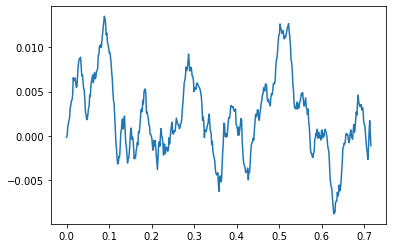

(-0.05033856075743093,
 1.0504970420628579,
 -0.04887689434293735,
 1.0481967671709709)

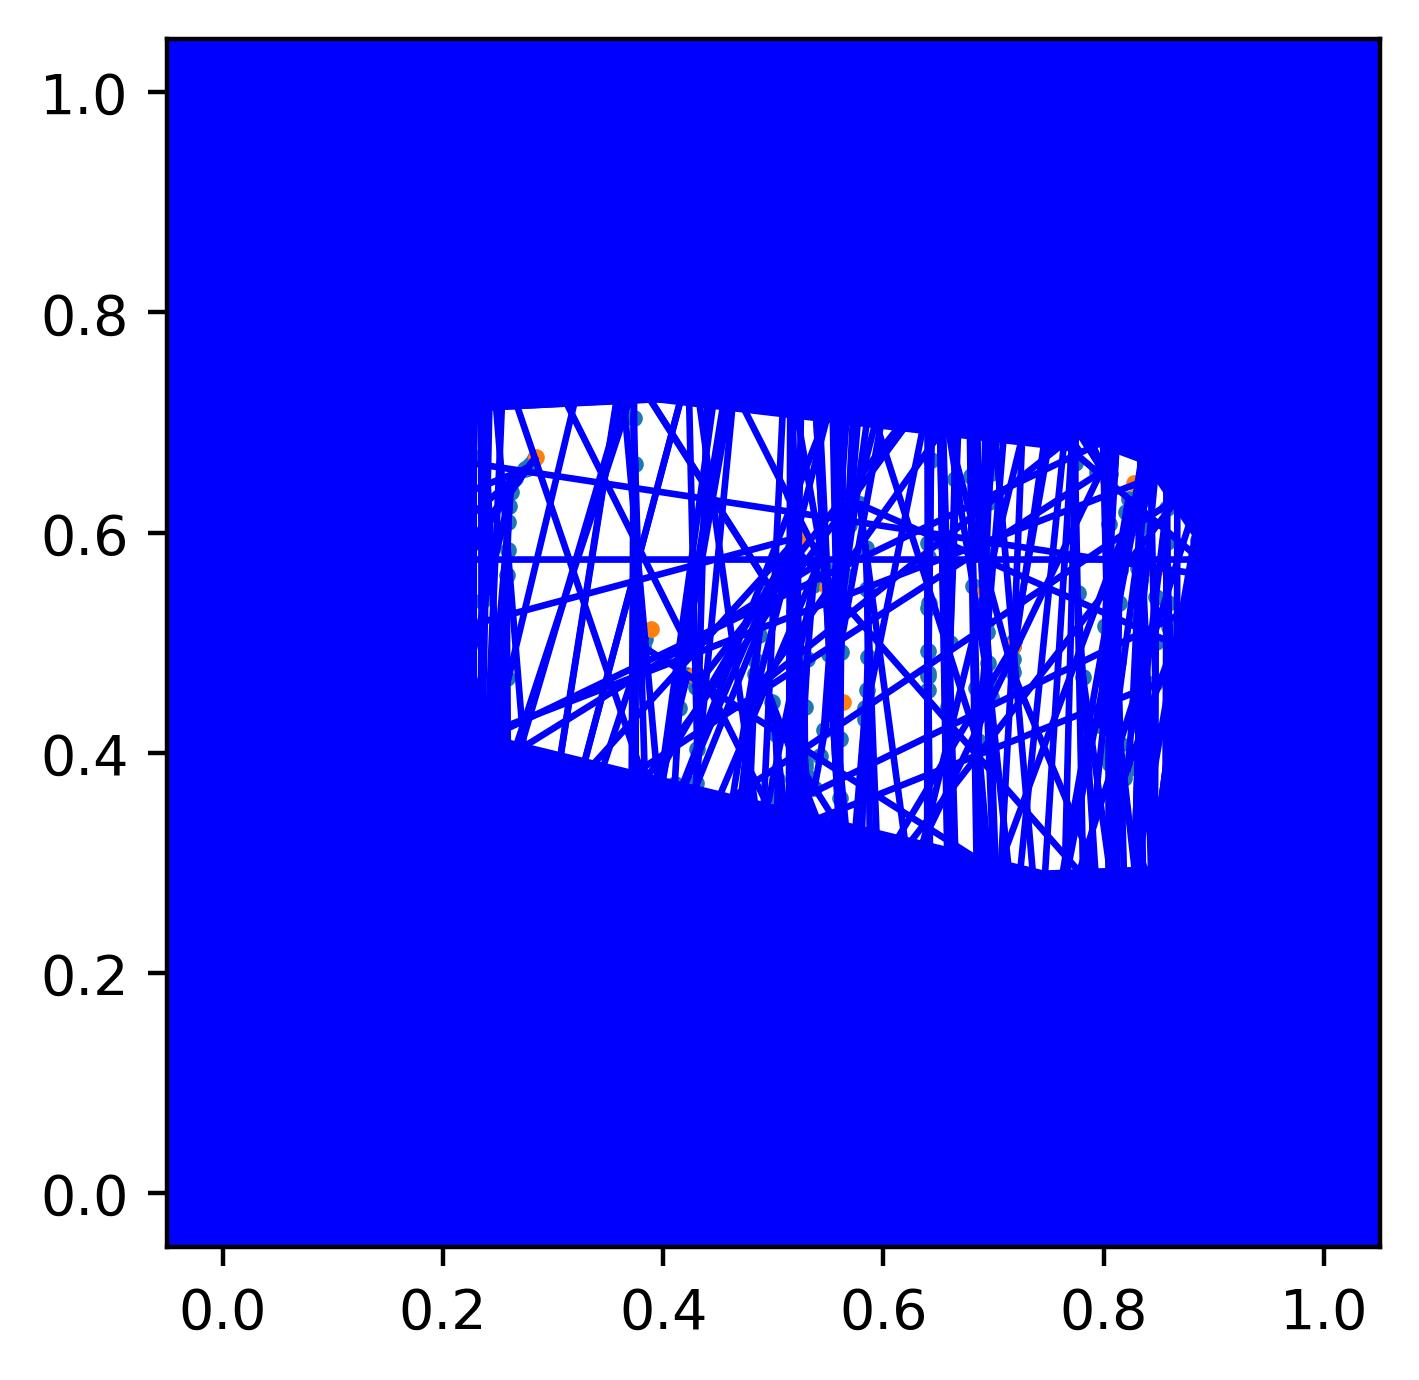

In [185]:
#plt.figure(dpi=300)
x,y,starts = sample(function_x, function_y, new_start_times, 500, noise="lagged", plot=True)

#plot_stroke_points(x[:10],y[:10],starts[:10])

size = 5,1
dpi = 400
#plt.figure(figsize=size, dpi=dpi)
plt.figure(dpi=dpi)

#prep_figure(dpi=300, size=(3,1))
plot_stroke_points(x,y,starts)
plt.axis('scaled')
#plt.axis('off')


In [21]:
x[:1][np.where(starts[:1] == 0)]

array([], dtype=float64)

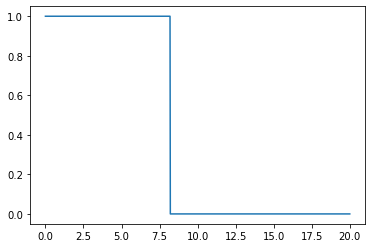

In [154]:
x_space = np.linspace(0,20,1000)
plt.plot(x_space, stroke_down_func(x_space))

In [155]:
print(starts)

[0.0, 0.59, 0.7899999999999998, 1.5499999999999998, 1.8899999999999997, 2.2499999999999996, 2.69, 2.82, 3.0499999999999994, 3.12, 3.3600000000000003, 3.700000000000001, 3.8400000000000016, 3.900000000000002, 4.130000000000003, 4.540000000000003, 5.220000000000002, 5.490000000000002, 5.640000000000002, 6.140000000000002, 6.220000000000002, 6.580000000000002, 6.660000000000004, 6.700000000000006, 6.890000000000004, 6.970000000000006, 7.260000000000005, 7.410000000000007, 7.670000000000009, 7.870000000000008, 8.020000000000007, 8.190000000000008]


In [140]:
distance_metric = lambda x,y: ((x[:-1] - x[1:])**2 + (y[:-1] - y[1:])**2)**(1/2)
distance = 0
stroke_dict = {"x": range(0,9), "y":range(0,9)}
# Loop through each stroke
xs = np.asarray(stroke_dict["x"])
ys = np.asarray(stroke_dict["y"])
distance += np.sum(distance_metric(xs,ys))
print(distance)

(8**2+8**2)**(1/2)

11.313708498984761


11.313708498984761